# Advanced RAG: Query Decomposition and Reasoning

by Tuana Celik ([LI](https://www.linkedin.com/in/tuanacelik/), [Twitter](https://x.com/tuanacelik))

> This is part one of the **Advanced Use Cases** series:
>
> 1️⃣ Extract Metadata from Queries to Improve Retrieval [cookbook](/cookbook/extracting_metadata_filters_from_a_user_query) & [full article](/blog/extracting-metadata-filter)
>
> 2️⃣ Query Expansion [cookbook](/cookbook/query-expansion) & [full article](/blog/query-expansion)
>
> 3️⃣ **Query Decomposition & the [full article](/blog/query-decomposition)**
>
> 4️⃣ [Automated Metadata Enrichment](/cookbook/metadata_enrichment)

Query decomposition is a technique we can use to decompose complex queries into simpler steps, answering each sub-question, and getting an LLM to reason about the final answer based on the answers to the sub-questions.

In this recipe, we're using the structured output functionality (currently in beta) by OpenAI to construct `Questions` which lists the sub-questions based on the original question, as well as keeping track of the intermediate answers to each question.

## 📺 Code Along

<iframe width="560" height="315" src="https://www.youtube.com/embed/kR4pVvBnOII?si=iBNQwX0rQMzzg0my" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

In [ ]:
!pip install haystack-ai
!pip install pyarrow==15.0.2
!pip install datasets
!pip install cohere-haystack

In [2]:
from haystack import Document, component
from haystack.components.builders import PromptBuilder
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.openai_utils import _convert_message_to_openai_format
from haystack.dataclasses import ChatMessage, StreamingChunk
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

from datasets import load_dataset
from openai import OpenAI, Stream
from openai.types.chat import ChatCompletion, ChatCompletionChunk
from typing import List, Any, Dict, Optional, Callable, Union
from pydantic import BaseModel

In [ ]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
  os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key:")

if "COHERE_API_KEY" not in os.environ:
  os.environ["COHERE_API_KEY"] = getpass("Cohere API Key:")

OpenAI API Key:··········
Cohere API Key:··········


## Load the Dataset

For this demo, we're using the `Tuana/game-of-thrones` dataset on Hugging Face, and we are using a Cohere embedding model to embed the contents.

In [ ]:
document_store = InMemoryDocumentStore()

dataset = load_dataset("Tuana/game-of-thrones", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

doc_embedder = CohereDocumentEmbedder(model="embed-multilingual-v3.0")
docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])

Calculating embeddings: 100%|██████████| 74/74 [01:24<00:00,  1.15s/it]


2357

## 🧪 Experimental Addition to the OpenAIGenerator for Structured Output Support

> 🚀 This step is a completely optional advanced step

Let's extend the `OpenAIGeneraotor` to be able to make use of the [strctured output option by OpenAI](https://platform.openai.com/docs/guides/structured-outputs/introduction). Below, we extend the class to call `self.client.beta.chat.completions.parse` if the user has provides a `respose_format` in `generation_kwargs`. This will allow us to provifde a Pydantic Model to the gnerator and request our generator to respond with structured outputs that adhere to this Pydantic schema.

In [ ]:
class OpenAIGenerator(OpenAIGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @component.output_types(replies=List[str], meta=List[Dict[str, Any]], structured_reply=BaseModel)
    def run(self, prompt: str, streaming_callback: Optional[Callable[[StreamingChunk], None]] = None, generation_kwargs: Optional[Dict[str, Any]] = None,):
      generation_kwargs = {**self.generation_kwargs, **(generation_kwargs or {})}
      if "response_format" in generation_kwargs.keys():
        message = ChatMessage.from_user(prompt)
        if self.system_prompt:
            messages = [ChatMessage.from_system(self.system_prompt), message]
        else:
            messages = [message]

        streaming_callback = streaming_callback or self.streaming_callback
        openai_formatted_messages = [_convert_message_to_openai_format(message) for message in messages]
        completion: Union[Stream[ChatCompletionChunk], ChatCompletion] = self.client.beta.chat.completions.parse(
            model=self.model,
            messages=openai_formatted_messages,
            **generation_kwargs)
        completions = [self._build_structured_message(completion, choice) for choice in completion.choices]
        for response in completions:
            self._check_finish_reason(response)

        return {
            "replies": [message.content for message in completions],
            "meta": [message.meta for message in completions],
            "structured_reply": completions[0].content
        }
      else:
          return super().run(prompt, streaming_callback, generation_kwargs)

    def _build_structured_message(self, completion: Any, choice: Any) -> ChatMessage:
        chat_message = ChatMessage.from_assistant(choice.message.parsed or "")
        chat_message.meta.update(
            {
                "model": completion.model,
                "index": choice.index,
                "finish_reason": choice.finish_reason,
                "usage": dict(completion.usage),
            }
        )
        return chat_message

## Define the Pydantic Model

For query expansion, we want to keep track of intermediate questions that can be answered independently. So, below we define a `Questions` schema. Each `Question` is made up a `question` and an `answer`

In [ ]:
class Question(BaseModel):
    question: str
    answer: Optional[str] = None

class Questions(BaseModel):
    questions: list[Question]

## Define the Query Decomposition Prompt

The first step in our application will be to decompose a question. We define our first `splitter_prompt` instructing an LLM to take the question step by steo and produce multiple sub questions.

In [ ]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder

splitter_prompt = """
You are a helpful assistant that prepares queries that will be sent to a search component.
Sometimes, these queries are very complex.
Your job is to simplify complex queries into multiple queries that can be answered
in isolation to eachother.

If the query is simple, then keep it as it is.
Examples
1. Query: Did Microsoft or Google make more money last year?
   Decomposed Questions: [Question(question='How much profit did Microsoft make last year?', answer=None), Question(question='How much profit did Google make last year?', answer=None)]
2. Query: What is the capital of France?
   Decomposed Questions: [Question(question='What is the capital of France?', answer=None)]
3. Query: {{question}}
   Decomposed Questions:
"""

builder = PromptBuilder(splitter_prompt)
llm = OpenAIGenerator(model="gpt-4o-mini", generation_kwargs={"response_format": Questions})

## Define a Multi Text Embedder and Retriever

Since we will likely be needing to answer multiple question, let's define a Milti Question Embedder and Retriever. This way, we can have 1 component that can accept multiple questsions, embed them, and another component that can retireve documents that relate to each question too.

In [ ]:
@component
class CohereMultiTextEmbedder:
    def __init__(self, model: str = "embed-multilingual-v3.0"):
        self.model = model
        self.query_embedder = CohereTextEmbedder(model=self.model)

    @component.output_types(embeddings=List[List[float]])
    def run(self, questions: BaseModel):
        embeddings = []
        for question in questions.questions:
          embeddings.append(self.query_embedder.run(question.question)["embedding"])
        return {"embeddings": embeddings}

In [ ]:
@component
class MultiQueryInMemoryEmbeddingRetriever:

    def __init__(self, retriever: InMemoryEmbeddingRetriever, top_k: int = 3):

        self.retriever = retriever
        self.question_context_pairs = []
        self.top_k = top_k

    @component.output_types(question_context_pairs=List[Dict])
    def run(self, queries: BaseModel, query_embeddings: List[List[float]],top_k: int = None):
        if top_k != None:
          self.top_k = top_k
        for query, embedding in zip(queries.questions, query_embeddings):
          result = self.retriever.run(query_embedding = embedding, top_k = self.top_k)
          self.question_context_pairs.append({"question": query.question, "documents": {doc.content for doc in result["documents"]}})
        return {"question_context_pairs": self.question_context_pairs}

## Define the Prompt to Answer Multiple Questions

Once we have our decomposed questions, we need to instruct an LLM to answer each question based on the context for each question.

In [ ]:
multi_query_template = """
You are a helpful assistant that can answer complex queries.
Here is the original question you were asked: {{question}}

And you have split the task into the following questions:
{% for pair in question_context_pairs %}
  {{pair.question}}
{% endfor %}

Here are the question and context pairs for each question.
For each question, generate the question answer pair as a structured output
{% for pair in question_context_pairs %}
  Question: {{pair.question}}
  Context: {{pair.documents}}
{% endfor %}
Answers:
"""

multi_query_prompt = PromptBuilder(multi_query_template)


## Define the Prompt to Reason About the Final Answer

Our final step will be to instruct the LLM to reason about the final answer based on the decomposed questions and answers to each.

In [ ]:
reasoning_template = """
You are a helpful assistant that can answer complex queries.
Here is the original question you were asked: {{question}}

You have split this question up into simpler questoins that can be answered in
isolation.
Here are the questions and answers that you've generated
{% for pair in question_answer_pair %}
  {{pair}}
{% endfor %}

Reason about the final answer to the original query based on these questions and
aswers
Final Answer:
"""

resoning_prompt = PromptBuilder(reasoning_template)

## Final Step: Construct the Pipeline

In [ ]:
query_decomposition_pipeline = Pipeline()

query_decomposition_pipeline.add_component("prompt", PromptBuilder(splitter_prompt))
query_decomposition_pipeline.add_component("llm", OpenAIGenerator(model="gpt-4o-mini", generation_kwargs={"response_format": Questions}))

query_decomposition_pipeline.connect("prompt", "llm")

question = "Who has more siblings, Jamie or Sansa?"
result = query_decomposition_pipeline.run({"prompt":{"question": question}})
print(result["llm"]["structured_reply"])

questions=[Question(question='How many siblings does Jamie have?', answer=None), Question(question='How many siblings does Sansa have?', answer=None)]


In [ ]:
pipeline = Pipeline()

pipeline.add_component("prompt", PromptBuilder(splitter_prompt))
pipeline.add_component("llm", OpenAIGenerator(model="gpt-4o-mini", generation_kwargs={"response_format": Questions}))
pipeline.add_component("embedder", CohereMultiTextEmbedder(model="embed-multilingual-v3.0"))
pipeline.add_component("multi_query_retriever", MultiQueryInMemoryEmbeddingRetriever(InMemoryEmbeddingRetriever(document_store=document_store)))
pipeline.add_component("multi_query_prompt", PromptBuilder(multi_query_template))
pipeline.add_component("query_resolver_llm", OpenAIGenerator(model="gpt-4o-mini", generation_kwargs={"response_format": Questions}))
pipeline.add_component("reasoning_prompt", PromptBuilder(reasoning_template))
pipeline.add_component("reasoning_llm", OpenAIGenerator(model="gpt-4o-mini"))

pipeline.connect("prompt", "llm")
pipeline.connect("llm.structured_reply", "embedder.questions")
pipeline.connect("embedder.embeddings", "multi_query_retriever.query_embeddings")
pipeline.connect("llm.structured_reply", "multi_query_retriever.queries")
pipeline.connect("llm.structured_reply", "embedder.questions")
pipeline.connect("multi_query_retriever.question_context_pairs", "multi_query_prompt.question_context_pairs")
pipeline.connect("multi_query_prompt", "query_resolver_llm")
pipeline.connect("query_resolver_llm.structured_reply", "reasoning_prompt.question_answer_pair")
pipeline.connect("reasoning_prompt", "reasoning_llm")

🚅 Components
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
  - embedder: CohereMultiTextEmbedder
  - multi_query_retriever: MultiQueryInMemoryEmbeddingRetriever
  - multi_query_prompt: PromptBuilder
  - query_resolver_llm: OpenAIGenerator
  - reasoning_prompt: PromptBuilder
  - reasoning_llm: OpenAIGenerator
🛤️ Connections
  - prompt.prompt -> llm.prompt (str)
  - llm.structured_reply -> embedder.questions (BaseModel)
  - llm.structured_reply -> multi_query_retriever.queries (BaseModel)
  - embedder.embeddings -> multi_query_retriever.query_embeddings (List[List[float]])
  - multi_query_retriever.question_context_pairs -> multi_query_prompt.question_context_pairs (List[Dict])
  - multi_query_prompt.prompt -> query_resolver_llm.prompt (str)
  - query_resolver_llm.structured_reply -> reasoning_prompt.question_answer_pair (BaseModel)
  - reasoning_prompt.prompt -> reasoning_llm.prompt (str)

In [ ]:
question = "Who has more siblings, Jamie or Sansa?"
result = pipeline.run({"prompt":{"question": question},
              "multi_query_prompt": {"question": question},
              "reasoning_prompt": {"question": question}},
                      include_outputs_from=["query_resolver_llm"])

In [ ]:
print("The original query was split and resolved:\n")
for pair in result["query_resolver_llm"]["structured_reply"].questions:
  print(pair)
print("\nSo the original query is answered as follows:\n")
print(result["reasoning_llm"]["replies"][0])

The original query was split and resolved:

question='How many siblings does Jamie have?' answer='Jaime Lannister has one sibling, Cersei Lannister, who is his twin sister.'
question='How many siblings does Sansa have?' answer='Sansa Stark has five siblings: one older brother (Robb), one younger sister (Arya), and two younger brothers (Bran and Rickon), plus one older illegitimate half-brother (Jon Snow).'

So the original query is answered as follows:

To determine who has more siblings between Jaime and Sansa, we can analyze the information provided in the answers to the simpler questions.

- Jaime Lannister has **1 sibling**, which is Cersei Lannister.
- Sansa Stark has **5 siblings**, which include Robb, Arya, Bran, Rickon, and Jon Snow (considered a half-brother).

Since 5 (Sansa's siblings) is greater than 1 (Jaime's siblings), we can conclude that Sansa has more siblings than Jaime.

**Final Answer:** Sansa has more siblings than Jaime.


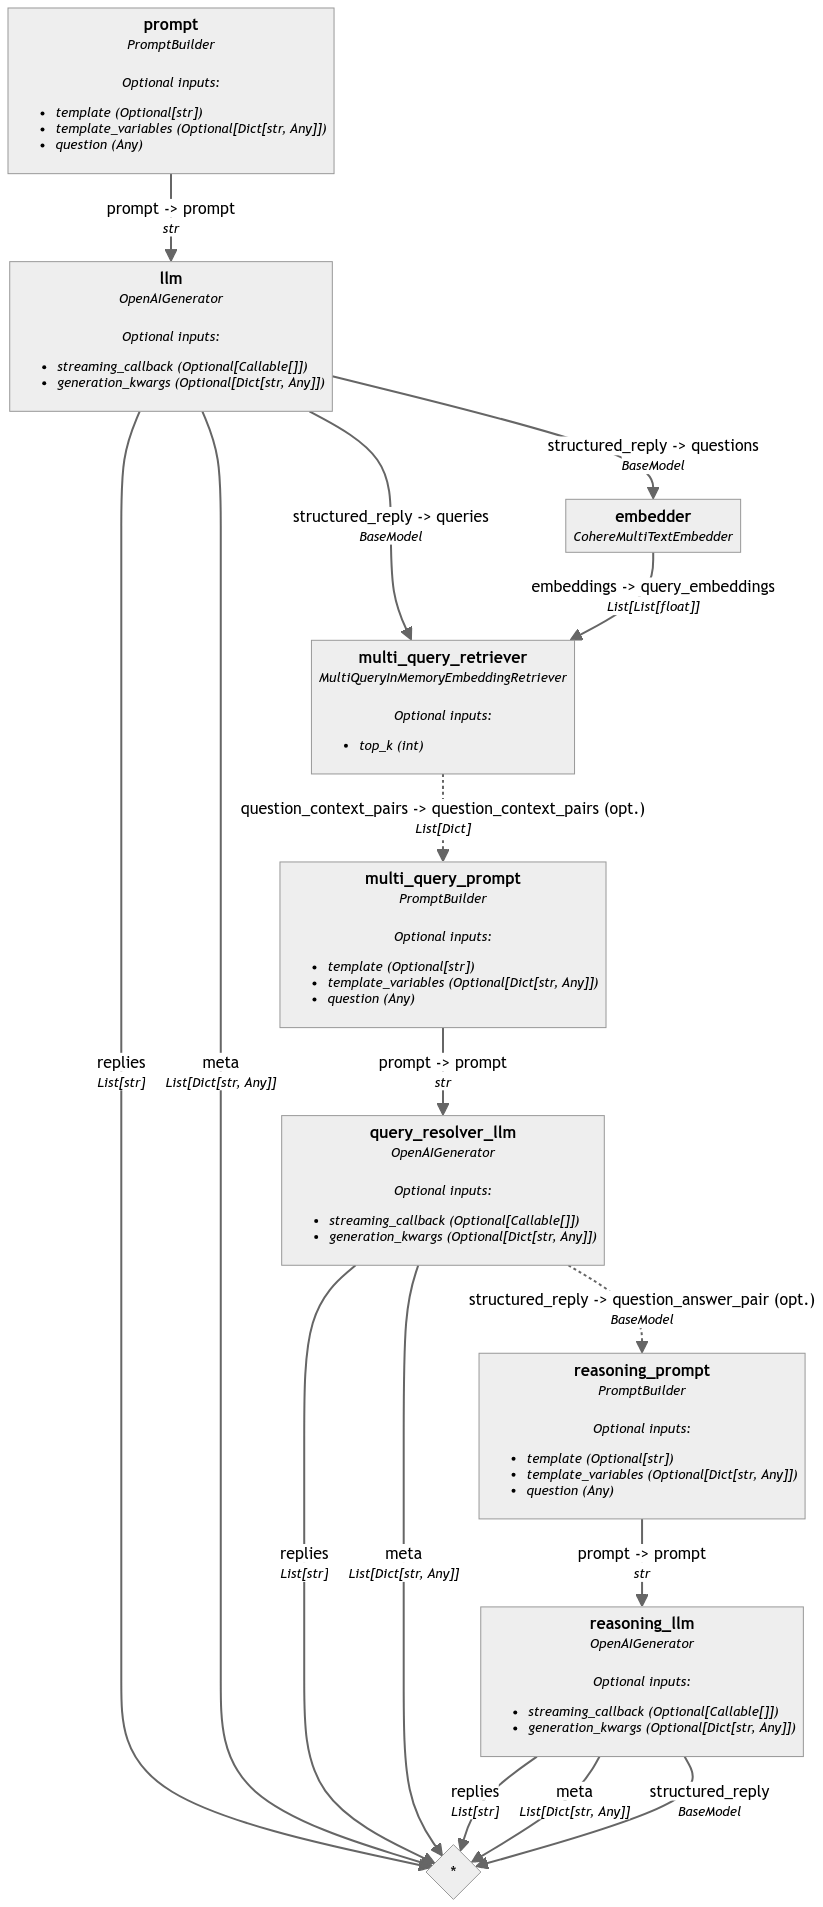

In [ ]:
pipeline.show()